# Velocity of the ellipse
How quick does the ellipse approach stars?


In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
from astropy import constants as const
from astropy import units as u
from astropy.time import Time
from astropy.table import Table

import sys
sys.path.append('/Users/james/Dropbox/python/cubehelix/')
import cubehelix

In [5]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [6]:
CMAP1 = cubehelix.cmap(start=0.5, rot=-0.6, sat=1.8, reverse=True)
CMAP2 = cubehelix.cmap(start=1.5, rot=-0.6, sat=1.8, reverse=True)

In [7]:
# SN 1987A Properties
t0 = Time({'year': 1987, 'month': 2, 'day': 23}, format='ymdhms')

c0_radec = SkyCoord.from_name('SN 1987A')

# Panagia (1999) https://ui.adsabs.harvard.edu/abs/1999IAUS..190..549P/abstract
d0 = 51.4 * u.kpc
d0_err= 1.2 * u.kpc

c0 = SkyCoord(ra=c0_radec.ra, dec=c0_radec.dec, distance=d0)

In [8]:
print(c0_radec)
print(d0.to('pc'))

<SkyCoord (ICRS): (ra, dec) in deg
    (83.86675, -69.26974167)>
51400.0 pc


In [9]:
# https://arxiv.org/abs/2012.02061
GCNS_file = '../../lonely_stars/GCNS_cat.fits'
GCNS = Table.read(GCNS_file, format='fits')

# past me already did this, yay! 
# https://github.com/jradavenport/lonely_stars/blob/main/GCNS_KDTree.ipynb
c1 = SkyCoord(ra = GCNS['RA'] * u.degree,
              dec = GCNS['DEC'] * u.degree,
              distance= GCNS['DIST_50'] * u.kpc,
              frame='icrs')

len(GCNS)
# xyz = c1.transform_to(coord.Galactocentric)

331312

In [10]:
t1 = Time.now()
# t1 = Time({'year': 2088, 'month': 2, 'day': 23}, format='ymdhms')
dt = t1-t0

# dt.sec
# dt.jd
dt.to('year')

<Quantity 35.02512536 yr>

In [11]:
c = d0.to('lyr') / 2 # dist to foci from ellipse center
a = (((dt.to('s') * const.c) / 2) + c).to('lyr') # the semi-major axis of ellipse
print(a-c)

d1 = (GCNS['DIST_50'] * u.kpc) # dist to GCNS stars

# OMG, astropy does the 3D distance computation between coordinates!
# need to work out how to propogate errors here, but it's pretty rad...
d2 = c1.separation_3d(c0) # dist from GCNS to SN 1987A

17.51256268042198 lyr


In [12]:
# A few things to compute for each GCNS object:

# 1. has it seen SN 1987A yet?
SNYES = d2.to('lyr').value <= (d0.to('lyr') + (dt.to('s') * const.c)).to('lyr').value
SNNO = ~SNYES

# 2. is it within the "SETI ellipse"?
EYES = (d1.to('lyr').value + d2.to('lyr').value) <= (2 * a.to('lyr').value)
ENO = ~EYES

# 3. is it within some tolerance of being ON the ellipse?
#    this could be within some range in distance or in time, thanks to speed of light...
tol = 0.1 # in lyr
OYES = np.abs((d1.to('lyr').value + d2.to('lyr').value) - (2 * a.to('lyr').value)) <= tol


print(len(d1))
print(sum(SNYES), sum(SNNO), sum(EYES), sum(OYES))
print(sum(SNYES) / (sum(SNYES) + sum(SNNO)))
print(sum(SNNO) / (sum(SNYES) + sum(SNNO)))
print(sum(EYES) / (sum(SNYES) + sum(SNNO)))

331312
192317 138995 25637 156
0.5804709759984547
0.41952902400154535
0.0773802337373835


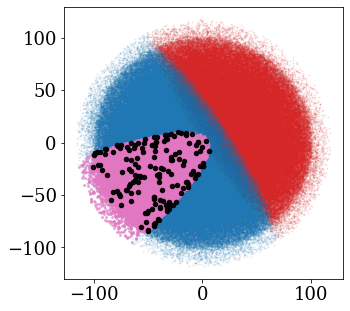

In [14]:
plt.figure(figsize=(5,5))
plt.scatter(GCNS['YCOORD_50'][SNNO], GCNS['ZCOORD_50'][SNNO], c='C3', s=1, alpha=0.1, rasterized=True)
plt.scatter(GCNS['YCOORD_50'][SNYES],GCNS['ZCOORD_50'][SNYES], c='C0', s=1, alpha=0.1, rasterized=True)
plt.scatter(GCNS['YCOORD_50'][EYES], GCNS['ZCOORD_50'][EYES], c='C6', s=4, alpha=0.5, rasterized=True)
plt.scatter(GCNS['YCOORD_50'][OYES], GCNS['ZCOORD_50'][OYES], c='k', s=20, alpha=0.95, rasterized=True)


In [16]:
# for these 157 stars, step thru a bunch of moments of time and, compute the Ellipsoid distance
# plot the ellipsoid "velocities"
# compare it to the various position angles (incl. the new one)

In [37]:
Ntime = 100
k=13
Time(t1.mjd - 0.5 + k/float(Ntime),format='mjd') -t0

<TimeDelta object: scale='tai' format='jd' value=12792.557038042569>

In [48]:
Ntime = 200
edist = np.zeros((Ntime, sum(OYES)))

for k in range(Ntime):
#     t1_k = Time({'year': 2022, 'month': k+1, 'day': 1}, format='ymdhms')
    t1_k = Time(t1.mjd - 90 + k,format='mjd')
    dt = t1_k-t0

    a = (((dt.to('s') * const.c) / 2) + c).to('lyr') # the semi-major axis of ellipse

    d1 = (GCNS['DIST_50'][OYES] * u.kpc) # dist to GCNS stars

    d2 = c1[OYES].separation_3d(c0) # dist from GCNS to SN 1987A
    
    edist_k = np.abs((d1.to('lyr').value + d2.to('lyr').value) - (2 * a.to('lyr').value))
    
    edist[k,:] = edist_k

In [171]:
# tee = np.arange(100)
# cee = 100
tee = 24951
cee = 84500
a1 = cee + tee/2
a2 = (tee + np.sqrt(tee**2 + (2*tee)**2))/2
print(a1, a2)
# plt.plot(tee, a1)
# plt.plot(tee, a2)

96975.5 40371.56605329862


In [179]:
Time((t0.mjd + 0.), format='mjd') - t0

<TimeDelta object: scale='tai' format='jd' value=0.0>

In [190]:
# does a expand at half c?
# a = (((dt.to('s') * const.c) / 2) + c).to('lyr') # the semi-major axis of ellipse
for k in range(10):
    t1_k = Time(t0.mjd + k*150, format='mjd')
    dt = t1_k-t0

    a = (((dt.to('s') * const.c) / 2) + c).to('lyr') # the semi-major axis of ellipse
    b = np.sqrt(a**2 - c**2)
    print(k, (dt.to('year')), a.value -c.value, b.to('lyr').value)



0 0.0 yr 0.0 0.0
1 0.4106776180698152 yr 0.20533880902803503 185.5368942114127
2 0.8213552361396304 yr 0.410677618070622 262.3889528102107
3 1.2320328858975333 yr 0.6160164429456927 321.3597252018902
4 1.6427105039673484 yr 0.8213552519737277 371.07447376436215
5 2.0533881220371635 yr 1.0266940610163147 414.87412730461665
6 2.464065740106979 yr 1.2320328700443497 454.4721138417919
7 2.8747433898648818 yr 1.4373716949339723 490.8862902958092
8 3.285421007934697 yr 1.6427105039765593 524.7798389912645
9 3.6960986260045123 yr 1.8480493130045943 556.6134144527992


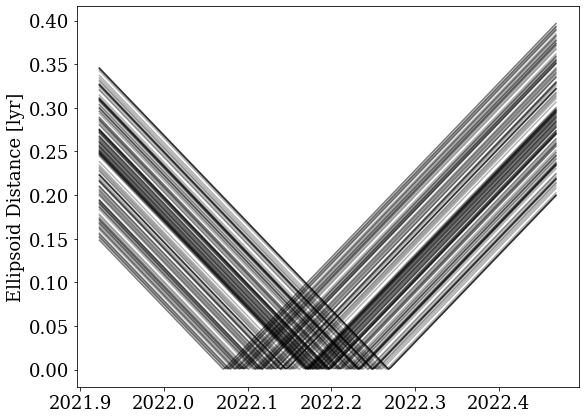

In [60]:
plt.figure(figsize=(9,7))
times = t1.mjd - 90 + np.arange(Ntime)
for k in range(sum(OYES)):
    plt.plot(Time(times,format='mjd').decimalyear, edist[:,k],  alpha=.3, c='k')
plt.ylabel('Ellipsoid Distance [lyr]')
plt.savefig('E_velocity1.png', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')

In [84]:
# np.nanmedian(np.abs(np.diff(edist[:,k])) / np.diff(Time(times,format='mjd').decimalyear))

Text(0, 0.5, 'Ellipsoid Velocity [lyr/yr]')

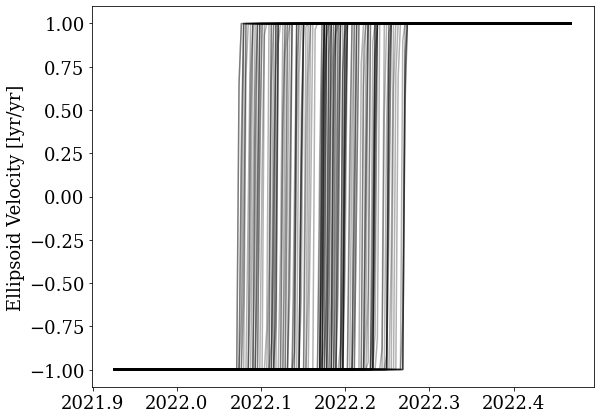

In [86]:
plt.figure(figsize=(9,7))
times = t1.mjd - 90 + np.arange(Ntime)
for k in range(sum(OYES)):
    plt.plot(Time(times,format='mjd').decimalyear[1:], 
             (np.diff(edist[:,k])) / np.diff(Time(times,format='mjd').decimalyear), 
             alpha=.3, c='k')
plt.ylabel('Ellipsoid Velocity [lyr/yr]')


<SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=20.8 pc, roll=0.0 deg): (x, y, z) in kpc
    [(  5.30394708, -22.9263364 , -12.74793023),
     (-10.4415771 ,  -9.73090668,  -0.23088828),
     ( -4.91897349,   3.56810232,  -1.64868052), ...,
     ( -7.91711365,  15.70242845,   4.23086735),
     (  5.75412655,  -9.7093757 , -12.5531844 ),
     ( -8.79760918,   2.70059168,   8.34489891)]>

In [98]:
nrand = 100000
c1sim = SkyCoord(ra = np.random.uniform(size=nrand, low=0, high=360) * u.degree,
              dec = np.random.uniform(size=nrand, low=-90, high=90) * u.degree,
              distance= np.random.uniform(size=nrand, low=1, high=30) * u.kpc,
              frame='icrs')

Ntime = 200
edist = np.zeros((Ntime, c1sim.size))

for k in range(Ntime):
#     t1_k = Time({'year': 2022, 'month': k+1, 'day': 1}, format='ymdhms')
    t1_k = Time(t1.mjd - 90 + k,format='mjd')
    dt = t1_k-t0

    a = (((dt.to('s') * const.c) / 2) + c).to('lyr') # the semi-major axis of ellipse

    d1 = c1sim.distance

    d2 = c1sim.separation_3d(c0) # dist from GCNS to SN 1987A
    
    edist_k = np.abs((d1.to('lyr').value + d2.to('lyr').value) - (2 * a.to('lyr').value))
    
    edist[k,:] = edist_k

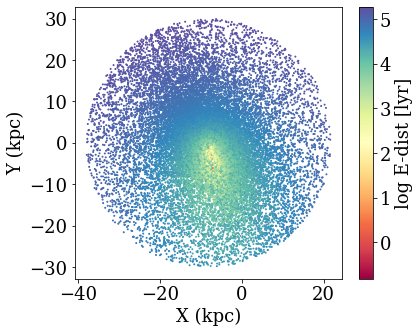

In [152]:
xyz = c1sim.transform_to(coord.Galactocentric)
Z1 = np.abs(xyz.z.value) < 4
plt.figure(figsize=(6,5))
plt.scatter(xyz.x[Z1], xyz.y[Z1], s=1, c=np.log10(np.nanmedian(edist,axis=0))[Z1], cmap=plt.cm.Spectral)
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')
cb = plt.colorbar()
cb.set_label('log E-dist [lyr]')

Text(0, 0.5, 'Ellipsoid Velocity [lyr/yr]')

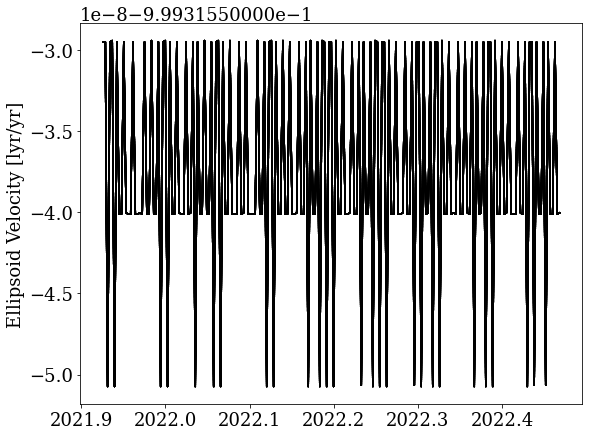

In [105]:
plt.figure(figsize=(9,7))
times = t1.mjd - 90 + np.arange(Ntime)
for k in range(0,c1sim.size,int(c1sim.size/50)):
    plt.plot(Time(times,format='mjd').decimalyear[1:], 
             (np.diff(edist[:,k])) / np.diff(Time(times,format='mjd').decimalyear), 
             alpha=.3, c='k')
plt.ylabel('Ellipsoid Velocity [lyr/yr]')

#     plt.plot(Time(times,format='mjd').decimalyear, edist[:,k],  alpha=.3, c='k')
# plt.ylabel('Ellipsoid Distance [lyr]')



In [110]:
(np.diff(edist[:,1000])) / np.diff(Time(times,format='mjd').decimalyear)

array([-0.99931553, -0.99931553, -0.99931555, -0.99931553, -0.99931553,
       -0.99931555, -0.99931553, -0.99931554, -0.99931554, -0.99931553,
       -0.99931554, -0.99931554, -0.99931554, -0.99931553, -0.99931554,
       -0.99931554, -0.99931554, -0.99931554, -0.99931553, -0.99931554,
       -0.99931554, -0.99931553, -0.99931554, -0.99931554, -0.99931553,
       -0.99931555, -0.99931553, -0.99931553, -0.99931555, -0.99931553,
       -0.99931554, -0.99931554, -0.99931553, -0.99931554, -0.99931554,
       -0.99931554, -0.99931553, -0.99931554, -0.99931554, -0.99931553,
       -0.99931555, -0.99931553, -0.99931554, -0.99931554, -0.99931553,
       -0.99931554, -0.99931554, -0.99931553, -0.99931555, -0.99931553,
       -0.99931553, -0.99931555, -0.99931553, -0.99931554, -0.99931554,
       -0.99931553, -0.99931554, -0.99931554, -0.99931554, -0.99931553,
       -0.99931554, -0.99931554, -0.99931553, -0.99931554, -0.99931554,
       -0.99931554, -0.99931554, -0.99931553, -0.99931554, -0.99

In [9]:
# the new angles
Alpha = c1.separation(c0).to('rad')

Z = np.sqrt( (c)**2 + d1.to('lyr')**2 - (2 * c * d1.to('lyr') * np.cos(Alpha.to('rad').value)) ) # law of cosines

Theta = np.arcsin(np.sin(Alpha.to('rad').value) * d1.to('lyr') / Z) # law of sines

e = c/a
b = np.sqrt(a**2 - c**2)
Phi = np.arctan(b/(a * e * np.sin(Theta)))

Gaia_Err = ((GCNS['DIST_84'] - GCNS['DIST_50']) + (GCNS['DIST_50'] - GCNS['DIST_16']))/2 * u.kpc
SCATTER = (Gaia_Err * np.sin(Phi)).to('lyr')
SCATTER

<Quantity [ 0.56183636,  2.1677575 ,  0.33386699, ...,  0.21166127,
           20.00089146,  8.68927931] lyr>

In [34]:
np.nanmedian(GCNS['ZCOORD_50'])

-0.5827108304998223

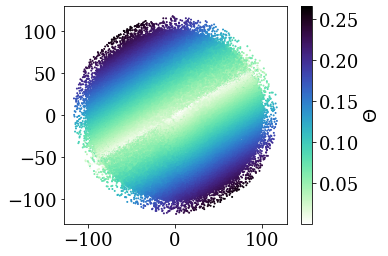

In [53]:
plt.figure(figsize=(5,4))

X1 = np.abs(GCNS['XCOORD_50']) < 15
plt.scatter(GCNS['YCOORD_50'][X1], GCNS['ZCOORD_50'][X1], c=Theta.to('deg')[X1],s=1, cmap=CMAP1)
cb = plt.colorbar()
cb.set_label('$\Theta$')


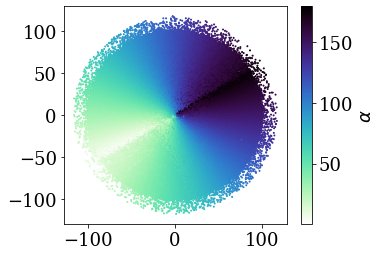

In [49]:
plt.figure(figsize=(5,4))

X1 = np.abs(GCNS['XCOORD_50']) < 15
plt.scatter(GCNS['YCOORD_50'][X1], GCNS['ZCOORD_50'][X1], c=Alpha.to('deg')[X1],s=1, cmap=CMAP1)
cb = plt.colorbar()
cb.set_label(r'$\alpha$')



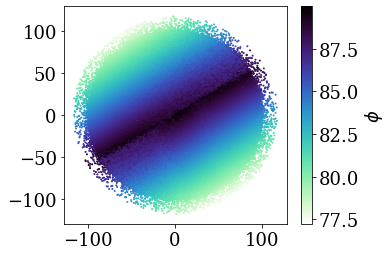

In [51]:
plt.figure(figsize=(5,4))

X1 = np.abs(GCNS['XCOORD_50']) < 15
plt.scatter(GCNS['YCOORD_50'][X1], GCNS['ZCOORD_50'][X1], c=Phi.to('deg')[X1],s=1, cmap=CMAP1)
cb = plt.colorbar()
cb.set_label(r'$\phi$')




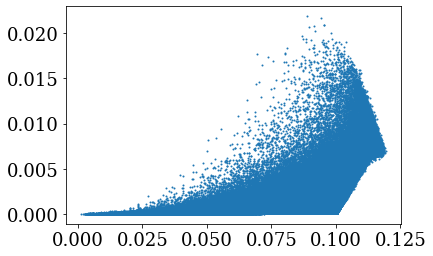

In [19]:
plt.scatter(GCNS['DIST_50'], Gaia_Err, s=1)

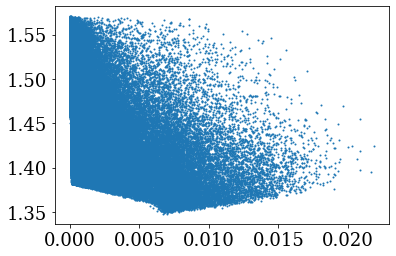

In [27]:
plt.scatter(Gaia_Err, Phi, s=1)

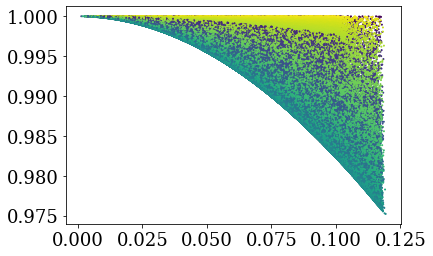

In [25]:
plt.scatter(GCNS[''], np.sin(Phi), s=1, c=Alpha)

## NEED TO DO:
This *looks* right... 
- Alpha is between 0 and 180deg (angular dist from every star to SN1987A)
- Theta is small b/c the ellipse is VERY ellongated, and all stars are very nearby us (so isolated to the extreme right side of the ellipse)
    - should make a figure of entire dataset to scale, color by theta..
- Phi is directly correlated with Theta, and is 90 (up/down) at theta=0 (behind us)

I need to make some tests or illustrations that show that the Phi that I'm computing is right. Maybe do for 1000 steps around the ellipse in theta? Or better yet, 1000 steps in Alpha... i did that in another notebook I think.

Text(0, 0.5, '$\\Theta$')

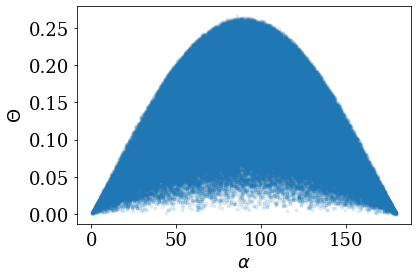

In [109]:
plt.figure()
plt.scatter(Alpha.to('deg').value[10000:],Theta.to('deg').value[10000:], marker='.',alpha=0.1)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\Theta$')
# Alpha.value

Text(0.5, 0, '$\\Theta$')

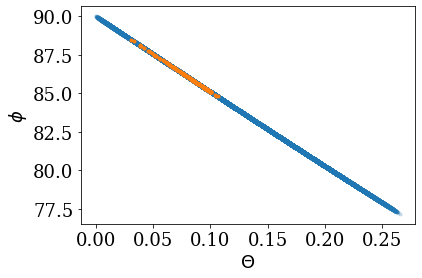

In [119]:
plt.figure()
plt.scatter(Theta.to('deg').value[10000:], Phi.to('deg').value[10000:],marker='.',alpha=0.1)
plt.scatter(Theta.to('deg')[OYES], Phi.to('deg').value[OYES],marker='.')
plt.ylabel(r'$\phi$')
plt.xlabel(r'$\Theta$')
# Alpha.value

Text(0.5, 0, '$\\alpha$')

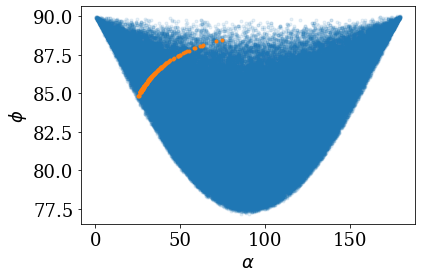

In [120]:
plt.figure()
plt.scatter(Alpha.to('deg').value[10000:], Phi.to('deg').value[10000:],marker='.',alpha=0.1)
plt.scatter(Alpha.to('deg')[OYES], Phi.to('deg').value[OYES],marker='.')
plt.ylabel(r'$\phi$')
plt.xlabel(r'$\alpha$')
# Alpha.value

331312
192135 139177 25484 134
0.579921644854397
0.42007835514560293
0.07691843338001642


In [11]:
# functions for drawing ellipses and circles to scale, BUT NOT ROTATED
# b/c I'm lazy...
def echoxy0(t, c, Ntheta=1000, foci=False):
    '''
    t: time since SNe in years
    c: half the dist to the SNe in lightyears
    '''

    a = 0.5 * (t + np.sqrt(t**2 + 4 * (c**2)))
    b = np.sqrt(0.5 * (t**2 + np.sqrt(t**4 + 4 * t**2 * c**2)))
    
    if foci:
#         foci_length = np.sqrt(np.abs(a**2 - b**2))
        fx = np.array([-c, c]) - c
        fy = np.array([0.,0.])
        return fx* u.lyr, fy* u.lyr

    else:
        theta = np.linspace(0, 2*np.pi, Ntheta) # the angle about the origin

        x = a * np.cos(theta) - c
        y = b * np.sin(theta)
        return x * u.lyr, y * u.lyr
    
    
def circxy0(t, c, x0=None,y0=None, Ntheta=1000):
    '''
    t: time since SNe in years
    c: half the dist to the SNe in lightyears
    '''
    a = 0.5 * (t + np.sqrt(t**2 + 4 * (c**2)))
    da = np.abs(a - c)
    acirc = a + da + c

    theta = np.linspace(0, 2*np.pi, Ntheta) # the angle about the origin
    
    x = acirc * np.cos(theta) - 2*c 
    y = acirc * np.sin(theta)        

    return x * u.lyr, y * u.lyr

def circxy(t, c, x0, y0, Ntheta=1000):
    r = 2*c + t
    theta = np.linspace(0, 2*np.pi, Ntheta) # the angle about the origin
    x = r * np.cos(theta) + x0
    y = r * np.sin(theta) + y0
    return x * u.lyr, y * u.lyr




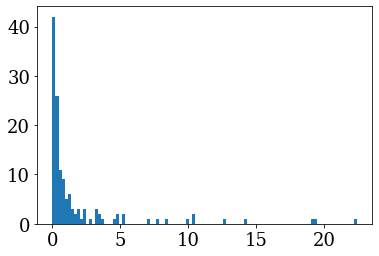

In [117]:
_ = plt.hist(SCATTER.value[OYES],bins=100)

In [13]:
t=dt.to('year').value

xyz87 = c0.transform_to(coord.Galactocentric(z_sun=0*u.pc, galcen_distance=8*u.kpc))
c1987_yz = np.sqrt(xyz87.y.to('lyr').value**2 + xyz87.z.to('lyr').value**2)
ang1987_yz = np.arcsin(xyz87.z.to('lyr').value/c1987_yz)
# print(ang1987_yz)

fx0,fy0 = echoxy0(t, c1987_yz/2, foci=True)
fx,fy = echoxy0(t, c1987_yz/2 , Ntheta=10000)

xpos = (fx - fx0[1]).to('pc')
ypos = fy.to('pc')

new_xpos = xpos * np.cos(ang1987_yz) + ypos*np.sin(ang1987_yz)  # Y
new_ypos = -xpos * np.sin(ang1987_yz) + ypos*np.cos(ang1987_yz) # Z


xpos0, ypos0 = xpos, ypos
new_xpos0, new_ypos0 = new_xpos, new_ypos

(-55.0, 15.0)

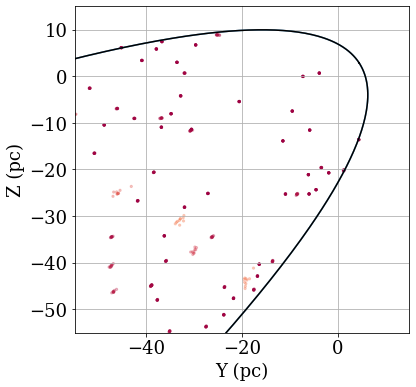

In [114]:
# lets inject some errors into the ellipse...
plt.figure(figsize=(6,6))
t=dt.to('year').value

xyz87 = c0.transform_to(coord.Galactocentric(z_sun=0*u.pc, galcen_distance=8*u.kpc))
plt.scatter(xyz87.y.to('pc').value, xyz87.z.to('pc').value, c='C2', marker='*', s=100)

Nsim=10
for k in range(Nsim):
    dc = 1.2/2*np.random.normal(size=1) * u.kpc
    
    fx0,fy0 = echoxy0(t, c1987_yz/2 + dc.to('lyr').value, foci=True)
    fx,fy = echoxy0(t, c1987_yz/2 + dc.to('lyr').value, Ntheta=10000)
#     cx,cy = circxy0(t, c.value + dc.to('lyr').value, Ntheta=10000)

    xpos = (fx - fx0[1]).to('pc')
    ypos = fy.to('pc')

    new_xpos = xpos * np.cos(ang1987_yz) + ypos*np.sin(ang1987_yz)  # Y
    new_ypos = -xpos * np.sin(ang1987_yz) + ypos*np.cos(ang1987_yz) # Z

    plt.plot(new_xpos, new_ypos, alpha=0.1, c='C0')

    ddist = np.abs((GCNS['DIST_16'] - GCNS['DIST_84'])/2) * np.random.normal(size=len(GCNS['DIST_50']))
    c1 = SkyCoord(ra = (GCNS['RA']) * u.degree,
              dec = (GCNS['DEC']) * u.degree,
              frame='icrs')
    # directional offset drops distance... so i dont add it until next
    c2 = c1.directional_offset_by(np.random.uniform(high=360,size=len(GCNS['RA']))*u.deg, 
                                  np.sqrt(GCNS['RA_ERROR']**2 + GCNS['DEC_ERROR']**2)*u.deg)
    c3 = SkyCoord(ra=c2.ra, dec=c2.dec,
                  distance= (GCNS['DIST_50'] + ddist) * u.kpc,
                  frame='icrs')
    xyz = c3.transform_to(coord.Galactocentric(z_sun=0, galcen_distance=8*u.kpc))
#     plt.scatter(xyz.y.to('pc').value[OYES], xyz.z.to('pc').value[OYES], 
#                 s=20, alpha=0.3, c='r', marker='.')
    plt.scatter(xyz.y.to('pc').value[OYES], xyz.z.to('pc').value[OYES], 
                s=20, alpha=0.3, c=SCATTER.value[OYES], marker='.', cmap=plt.cm.Spectral)


plt.plot(new_xpos0, new_ypos0, c='k')
plt.grid(True)
plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')

plt.xlim(-55,15) # center near us
plt.ylim(-55,15)
# plt.savefig('dist_err1.png', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')


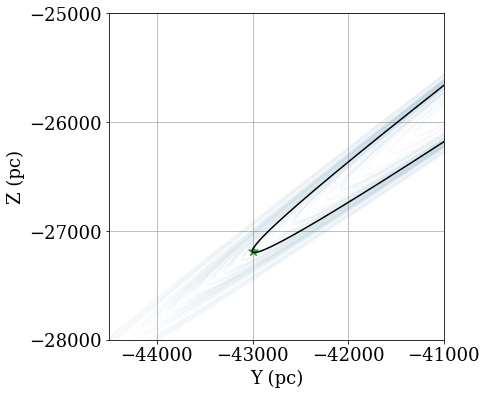

In [15]:
# lets inject some errors into the ellipse...
plt.figure(figsize=(6,6))
plt.scatter(xyz87.y.to('pc').value, xyz87.z.to('pc').value, c='C2', marker='*', s=100)

Nsim=100
for k in range(Nsim):
    dc = 1.2/2*np.random.normal(size=1) * u.kpc
    
    fx0,fy0 = echoxy0(t, c1987_yz/2 + dc.to('lyr').value, foci=True)
    fx,fy = echoxy0(t, c1987_yz/2 + dc.to('lyr').value, Ntheta=10000)
#     cx,cy = circxy0(t, c.value + dc.to('lyr').value, Ntheta=10000)

    xpos = (fx - fx0[1]).to('pc')
    ypos = fy.to('pc')

    new_xpos = xpos * np.cos(ang1987_yz) + ypos*np.sin(ang1987_yz)  # Y
    new_ypos = -xpos * np.sin(ang1987_yz) + ypos*np.cos(ang1987_yz) # Z

    plt.plot(new_xpos, new_ypos, alpha=0.02, c='C0')
    
plt.plot(new_xpos0, new_ypos0, c='k')
plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')

plt.xlim(-44500,-41500) # center near LMC
plt.ylim(-28000,-25000)
plt.xticks([-44000, -43000,-42000, -41000])
plt.yticks([-28000,-27000,-26000,-25000])
plt.grid(True)

# plt.savefig('dist_err2.png', dpi=150, bbox_inches='tight', pad_inches=0.25, facecolor='w')
